# GripPrint
- Unique "fingerprint" based on how users grip and interact with the dualsense controller.


### Model 1 Minimuan validation model- ontable or onhand


#### Collect data

In [6]:
# define a function to check the connection of the dualsense controller

def check_controller_connection():
    try:
        dualsense = ds.pydualsense()
        # Try to find and open the device
        device = dualsense._pydualsense__find_device()  # Access private method with name mangling
        if device:
            print("✅ Controller connected")
            connected = True
        else:
            print("❌ Controller not connected")
            connected = False
            
    except Exception as e:
        print("❌ Controller not connected")
        connected = False
    finally:
        if 'device' in locals():
            try:
                device.close()
            except:
                pass
    
    return connected



print("Is the controller connected?", check_controller_connection())

✅ Controller connected
Is the controller connected? True


In [7]:
# define a function to collect data from the dualsense controller with two labels: ontable and onhand
# save the data to a csv file

import os
import time
import pandas as pd
import pydualsense as ds

table_colunm=["timestamp", "gyroscope_pitch", "gyroscope_yaw", "gyroscope_roll", "accelerometer_x", "accelerometer_y", "accelerometer_z", "session_id", "label"]


def simple_data_collection(label: str, session_time: int = 500, collection_duration: int = 100000, csvfile_name:str="Simple_data.csv"):
    # parameters:
    # label: the label of the data collection
    # session_time: the time segment of the data collection in milliseconds
    # collection_duration: the duration of the data collection in milliseconds

    dualsense = ds.pydualsense()
    dualsense.init()    

    #  get the timestamp of the data collection
    timestamp = time.time()

    #  get the inertial data from the dualsense controller
    inertial_data = []
    start_time = time.time()
    session_id = int(time.time())
    
    while (time.time() - start_time) * 1000 < collection_duration:
        current_time = time.time()
        # Get sensor data from dualsense
        gyro = dualsense.state.gyro
        accel = dualsense.state.accelerometer
        
        # Create a data point
        data_point = [
            current_time,
            gyro.Pitch, gyro.Yaw, gyro.Roll,
            accel.X, accel.Y, accel.Z,
            session_id,
            label
        ]

        # update the data point in the console in one line 
        print(data_point, end='\r')

        #  append the data point to the inertial data
        inertial_data.append(data_point)
        
        # Update session_id every session_time milliseconds
        if ( current_time - start_time) * 1000 // session_time > session_id:
            session_id += 1
            
        time.sleep(0.001)  # Small delay to prevent overwhelming the controller
    
    #  save the inertial data to a csv file
    df = pd.DataFrame(inertial_data, columns=table_colunm)
    
    

 
    # Use csvfile_name as the target file
    if os.path.exists(csvfile_name):
        # Append data without header
        df.to_csv(csvfile_name, mode='a', header=False, index=False)
        print(f'Data appended to existing {csvfile_name}')
    else:
        # Create new file with header
        df.to_csv(csvfile_name, index=False)
        print(f'New file {csvfile_name} created')

    dualsense.close()









##### write a table for describing the data table column:

| Column Name | Description | Data Type | Unit/Range | 
|------------|-------------|-----------|------------| 
| timestamp | Time when the data was recorded | Numeric | Unix timestamp or datetime |
 | gyroscope_pitch | Rotation around the X-axis (front-to-back tilt) | Numeric | Degrees or Radians | 
 | gyroscope_yaw | Rotation around the Y-axis (left-to-right turn) | Numeric | Degrees or Radians | 
 | gyroscope_roll | Rotation around the Z-axis (side-to-side tilt) | Numeric | Degrees or Radians | 
 | accelerometer_x | Linear acceleration along X-axis (left/right) | Numeric | m/s² or g-force | 
 | accelerometer_y | Linear acceleration along Y-axis (forward/backward) | Numeric | m/s² or g-force |
  | accelerometer_z | Linear acceleration along Z-axis (up/down) | Numeric | m/s² or g-force | 
  | session_id | Unique identifier for each recording session | String/Integer | Identifier, collect 500 rows as one session |
   | label | Classification label or target variable | String/Integer | Class identifier |

##  Data Preprocessing



In [16]:
# Combine the two csv(two labels) into one csv file they have the same column names.
import pandas as pd



table_csv = 'inertial_data_table_1730446449.2779398.csv'
hand_csv = 'inertial_data_hand_1730446565.1342528.csv'

#  due the 0 value in the first session, delete the session_id=0 for both csv files
table_df = pd.read_csv(table_csv)
table_df = table_df[table_df['session_id'] != 0]
table_df.to_csv('inertial_data_table_processed.csv', index=False)

hand_df = pd.read_csv(hand_csv)
hand_df = hand_df[hand_df['session_id'] != 0]
hand_df.to_csv('inertial_data_hand_processed.csv', index=False)

#  combine the two csv files into one csv file
table_df = pd.read_csv('inertial_data_table_processed.csv')
hand_df = pd.read_csv('inertial_data_hand_processed.csv')
combined_df = pd.concat([table_df, hand_df], ignore_index=True)
combined_df.to_csv('inertial_data_combined_processed.csv', index=False)



### 1D CNN Model


In [1]:
# csv file ready
data_csv = 'inertial_data_combined_processed.csv'


In [2]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [29]:
# create a 1D CNN model 
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

data_df = pd.read_csv(data_csv)

all_columns = data_df.columns.tolist() 
print(all_columns)

# Define each session length be 470
SESSION_LENGTH=470


# Define features and label
features = all_columns[:-1]  # all columns except label
label = all_columns[-1]      # label column
print("Features:", features)
print("Label:", label)

# Define features explicitly (excluding session_id)
numeric_features = ['gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 
                   'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
N_FEATURES = len(numeric_features)  # Should be 6

def create_sequences(data, labels, session_length=SESSION_LENGTH):
    sequences = []
    sequence_labels = []
    
    for session_id in data['session_id'].unique():
        # Get data for this session
        session_data = data[data['session_id'] == session_id]
        session_label = labels[data['session_id'] == session_id].iloc[0]
        
        # Take first session_length rows
        session_data = session_data.head(session_length)
        
        # Skip if session has less than required length
        if len(session_data) < session_length:
            print(f"Skipping session {session_id} - insufficient length")
            continue
            
        # Extract only numeric features (excluding session_id)
        sequence = session_data[numeric_features].values
        sequences.append(sequence)
        sequence_labels.append(session_label)
    
    sequences = np.array(sequences)
    sequence_labels = np.array(sequence_labels)
    
    print(f"Sequence shape: {sequences.shape}")  # Should be (n_sessions, session_length, 6)
    return sequences, sequence_labels

# Normalize only the numeric features
scaler = StandardScaler()
data_df[numeric_features] = scaler.fit_transform(data_df[numeric_features])

# Create sequences
x_sequences, y_sequences = create_sequences(
    data_df,
    data_df[label],
    session_length=SESSION_LENGTH
)

# Verify the shape
print("\nData shapes:")
print(f"X sequences shape: {x_sequences.shape}")  # Should be (n_sessions, SESSION_LENGTH, 6)
print(f"Y sequences shape: {y_sequences.shape}")  # Should be (n_sessions,)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_sequences)

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    x_sequences, y, test_size=0.2, random_state=42
)

print("\nTrain/Test shapes:")
print(f"X train shape: {x_train.shape}")  # Should have 6 features
print(f"X test shape: {x_test.shape}")    # Should have 6 features
print(f"Y train shape: {y_train.shape}")
print(f"Y test shape: {y_test.shape}")



['timestamp', 'gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'session_id', 'label']
Features: ['timestamp', 'gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'session_id']
Label: label
Skipping session 150 - insufficient length
Skipping session 225 - insufficient length
Skipping session 349 - insufficient length
Sequence shape: (395, 470, 6)

Data shapes:
X sequences shape: (395, 470, 6)
Y sequences shape: (395,)

Train/Test shapes:
X train shape: (316, 470, 6)
X test shape: (79, 470, 6)
Y train shape: (316,)
Y test shape: (79,)


In [30]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

N_FEATURES=6

def build_1d_cnn_model(input_shape=(SESSION_LENGTH, N_FEATURES), output_shape=1):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First Conv1D block
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Second Conv1D block
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Dense layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model






In [31]:

# Create and compile model
model = build_1d_cnn_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nModel Summary:")
model.summary()


Model Summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 470, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 468, 64)        │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 234, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 232, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 116, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3712)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       237,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,089 (957.38 KB)

 Trainable params: 245,089 (957.38 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train model
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7375 - loss: 0.5027 - val_accuracy: 1.0000 - val_loss: 0.0608
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 3.2073e-05
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6220e-04 - val_accuracy: 1.0000 - val_loss: 3.1886e-06
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1098e-04 - val_accuracy: 1.0000 - val_loss: 8.6833e-07
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4839e-04 - val_accuracy: 1.0000 - val_loss: 4.3553e-07
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1732e-05 - val_accuracy: 1.0000 - val_loss: 3.0848e-07
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9505e-04 - val_acc


Test accuracy: 1.0000


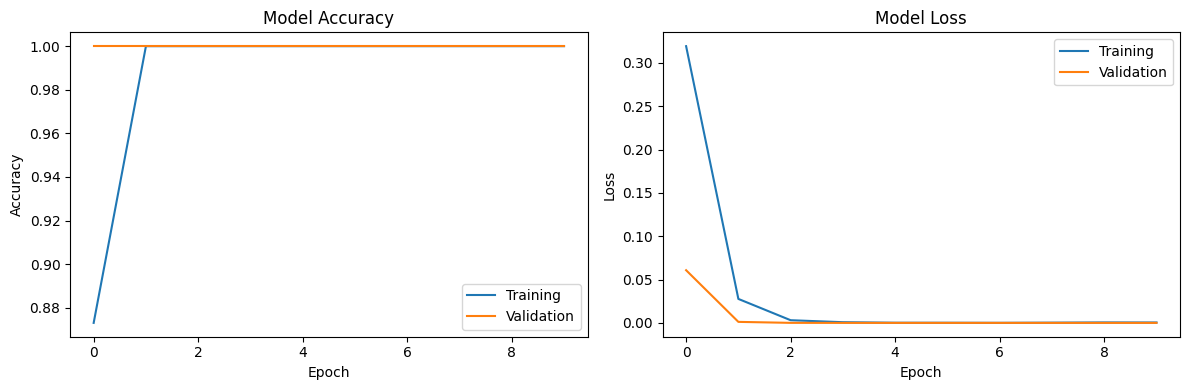

In [36]:
# export the tf model file 
import matplotlib.pyplot as plt
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [42]:
# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.save')

# Save the model
model.save('gesture_model.keras')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.save')

print("Saved files:")
print("- gesture_model.keras")
print("- scaler.save")
print("- label_encoder.save")

Saved files:
- gesture_model.keras
- scaler.save
- label_encoder.save
